# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [92]:
# Imports

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data.sampler import SubsetRandomSampler

from torchvision import datasets, models, transforms, utils
import torchvision.transforms as transforms

import numpy as np
import time
import os
import argparse
import copy
from PIL import Image
import matplotlib.pyplot as plt
import json
from collections import OrderedDict
from pprint import pprint
from glob import glob

%matplotlib inline
seed = 42

In [41]:
# Specify which device will be used for training model
device_id = 1
torch.cuda.set_device(device_id)
os.environ['CUDA_VISIBLE_DEVICES'] = str(device_id)
device = torch.device(device_id if torch.cuda.is_available() else 'cpu')
print(device)

cuda:1


## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). You can [download the data here](https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip). The dataset is split into two parts, training and validation. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. If you use a pre-trained network, you'll also need to make sure the input data is resized to 224x224 pixels as required by the networks.

The validation set is used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks available from `torchvision` were trained on the ImageNet dataset where each color channel was normalized separately. For both sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.

In [9]:
data_dir = './flower_data'
train_dir = os.path.join(data_dir, 'train')
valid_dir = os.path.join(data_dir, 'valid')

image_files = np.array(glob("%s/*/*/*" % data_dir))
train_image_files = np.array(glob("%s/*/*" % train_dir))
valid_image_files = np.array(glob("%s/*/*" % valid_dir))
n_image_files = len(image_files)
n_train_image_files = len(train_image_files)
n_valid_image_files = len(valid_image_files)

# Print number of images in each dataset
print('There are %d total images.' % n_image_files)
print('There are %d (%.2f%%) total train images.' % (n_train_image_files, n_train_image_files / n_image_files * 100))
print('There are %d (%.2f%%) total valid images.' % (n_valid_image_files, n_valid_image_files / n_image_files * 100))

There are 7370 total images.
There are 6552 (88.90%) total train images.
There are 818 (11.10%) total valid images.


In [133]:
batch_size = 16  # hyper parameters
resize_size = 256

# Define your transforms for the training and validation sets
means = (0.485, 0.456, 0.406)
stds = (0.229, 0.224, 0.225)
train_transforms = transforms.Compose([
    transforms.RandomRotation(45),  # TODO: optimizable
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    # transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(means, stds)
])

valid_transforms = transforms.Compose([
    transforms.Resize(resize_size),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(means, stds)
])

# Load the datasets with ImageFolder
image_datasets = dict()
image_datasets['train'] = datasets.ImageFolder(
    train_dir, transform=train_transforms)
image_datasets['valid'] = datasets.ImageFolder(
    valid_dir, transform=valid_transforms)

# TODO: Using the image datasets and the trainforms, define the dataloaders
dataloaders = dict()
dataloaders['train'] = torch.utils.data.DataLoader(
    image_datasets['train'], batch_size=batch_size, shuffle=True)
dataloaders['valid'] = torch.utils.data.DataLoader(
    image_datasets['valid'], batch_size=batch_size, shuffle=True)

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}
class_names = image_datasets['train'].classes
n_class_names = len(class_names)

print('dataset_sizes', dataset_sizes)
print('n_class_names', n_class_names)

dataset_sizes {'train': 6552, 'valid': 818}
n_class_names 102


### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [16]:
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(16, 3, 224, 224)
(16,)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


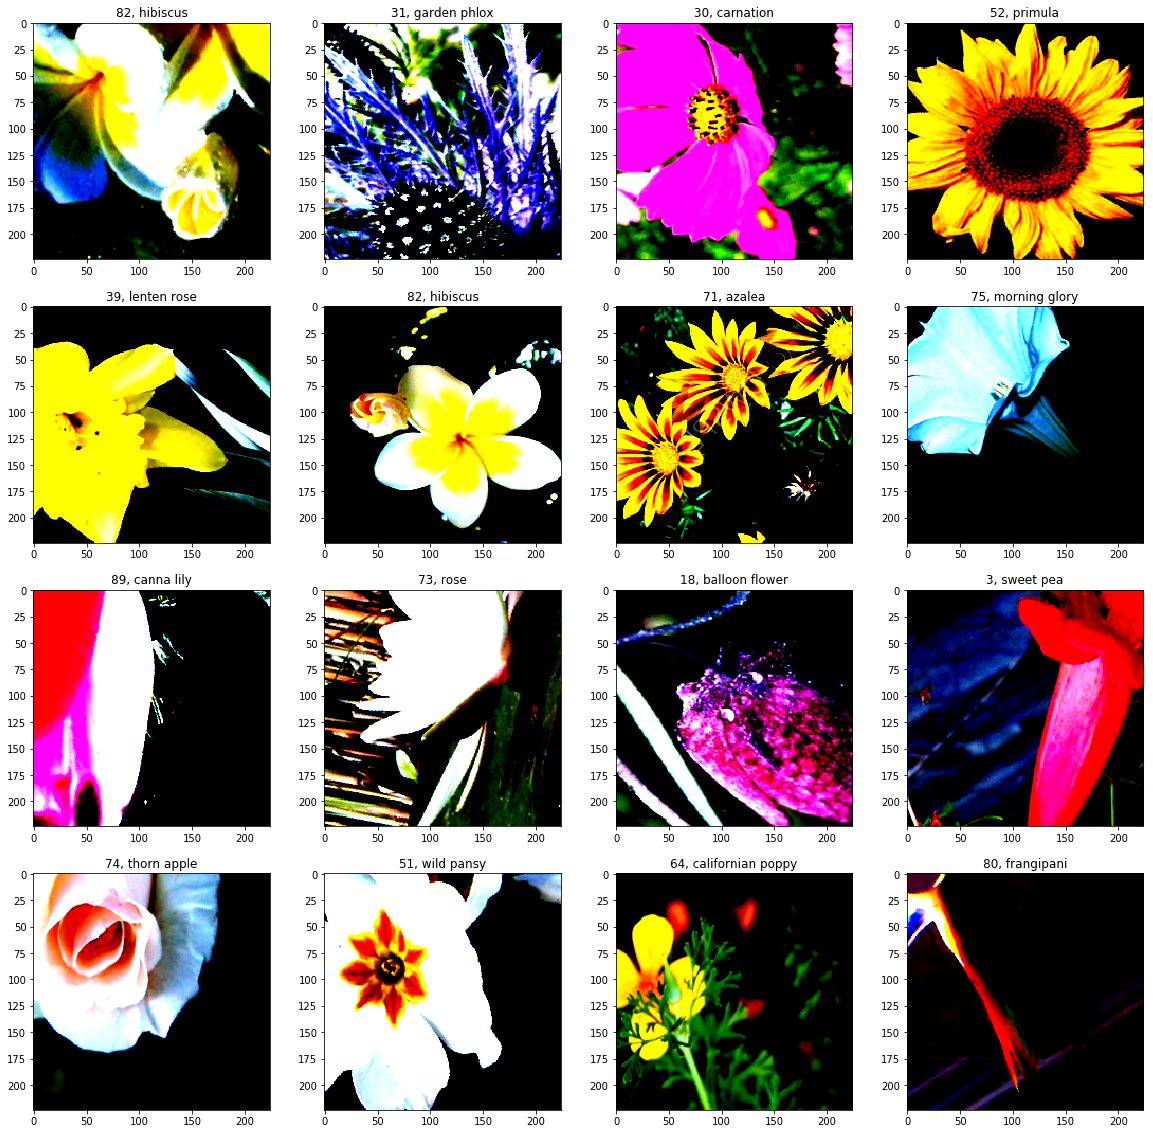

In [27]:
# Visualise data
dataiterator = iter(dataloaders['train'])
imgs, labels = dataiterator.next()
imgs = imgs.numpy()
labels = labels.numpy()
print(imgs.shape)
print(labels.shape)

fig = plt.figure(figsize=(20, 20))
for indx in range(batch_size):
    ax = fig.add_subplot(4, 4, indx + 1)
    plt.imshow(np.transpose((imgs[indx])))
    ax.set_title('%d, %s' % (labels[indx], cat_to_name[str(labels[indx] + 1)]))

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. If you want to talk through it with someone, chat with your fellow students! You can also ask questions on the forums or join the instructors in office hours.

Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

In [49]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    global dataloaders
    global device
    global dataset_sizes

    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss,
                                                       epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)

    return model

In [205]:
# Build and train your network

# load pre trained model and
# Freeze parameters so we don't backprop through them
model = models.vgg16(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

# Extended
num_features = model.classifier[0].in_features
classifier = nn.Sequential(
    OrderedDict([
        ('dense', nn.Linear(num_features, 512)),
        ('relu', nn.ReLU()),
        ('dropout', nn.Dropout(p=0.2)),
        ('dense2', nn.Linear(512, 100)),
        ('relu2', nn.ReLU()),
        ('dropout2', nn.Dropout(p=0.2)),
        ('dense3', nn.Linear(100, 102)),
        ('output', nn.LogSoftmax(dim=1)),
    ]))

model.classifier = classifier
print('num_features', num_features)
print(model)

num_features 25088
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=Fals

In [51]:
num_epochs = 10
model = model.cuda() if torch.cuda.is_available() else model
criterion = nn.CrossEntropyLoss()  # loss
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)  # optimizer
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
model = train_model(
    model, criterion, optimizer, exp_lr_scheduler, num_epochs=num_epochs)

Epoch 0/9
----------
train Loss: 3.3299 Acc: 0.2408
valid Loss: 1.5246 Acc: 0.6002
Epoch 1/9
----------
train Loss: 2.1021 Acc: 0.4574
valid Loss: 1.0645 Acc: 0.7005
Epoch 2/9
----------
train Loss: 1.6987 Acc: 0.5470
valid Loss: 0.9058 Acc: 0.7347
Epoch 3/9
----------
train Loss: 1.5414 Acc: 0.5842
valid Loss: 0.7813 Acc: 0.7958
Epoch 4/9
----------
train Loss: 1.4118 Acc: 0.6221
valid Loss: 0.7101 Acc: 0.8032
Epoch 5/9
----------
train Loss: 1.3601 Acc: 0.6407
valid Loss: 0.7483 Acc: 0.7934
Epoch 6/9
----------
train Loss: 1.3012 Acc: 0.6595
valid Loss: 0.6561 Acc: 0.8301
Epoch 7/9
----------
train Loss: 1.1342 Acc: 0.6935
valid Loss: 0.5216 Acc: 0.8667
Epoch 8/9
----------
train Loss: 1.0295 Acc: 0.7152
valid Loss: 0.5023 Acc: 0.8667
Epoch 9/9
----------
train Loss: 0.9818 Acc: 0.7337
valid Loss: 0.4817 Acc: 0.8790
Training complete in 16m 53s
Best val Acc: 0.878973


## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [53]:
dataloaders['train'].dataset.class_to_idx

{'1': 0,
 '10': 1,
 '100': 2,
 '101': 3,
 '102': 4,
 '11': 5,
 '12': 6,
 '13': 7,
 '14': 8,
 '15': 9,
 '16': 10,
 '17': 11,
 '18': 12,
 '19': 13,
 '2': 14,
 '20': 15,
 '21': 16,
 '22': 17,
 '23': 18,
 '24': 19,
 '25': 20,
 '26': 21,
 '27': 22,
 '28': 23,
 '29': 24,
 '3': 25,
 '30': 26,
 '31': 27,
 '32': 28,
 '33': 29,
 '34': 30,
 '35': 31,
 '36': 32,
 '37': 33,
 '38': 34,
 '39': 35,
 '4': 36,
 '40': 37,
 '41': 38,
 '42': 39,
 '43': 40,
 '44': 41,
 '45': 42,
 '46': 43,
 '47': 44,
 '48': 45,
 '49': 46,
 '5': 47,
 '50': 48,
 '51': 49,
 '52': 50,
 '53': 51,
 '54': 52,
 '55': 53,
 '56': 54,
 '57': 55,
 '58': 56,
 '59': 57,
 '6': 58,
 '60': 59,
 '61': 60,
 '62': 61,
 '63': 62,
 '64': 63,
 '65': 64,
 '66': 65,
 '67': 66,
 '68': 67,
 '69': 68,
 '7': 69,
 '70': 70,
 '71': 71,
 '72': 72,
 '73': 73,
 '74': 74,
 '75': 75,
 '76': 76,
 '77': 77,
 '78': 78,
 '79': 79,
 '8': 80,
 '80': 81,
 '81': 82,
 '82': 83,
 '83': 84,
 '84': 85,
 '85': 86,
 '86': 87,
 '87': 88,
 '88': 89,
 '89': 90,
 '9': 91,
 '90

In [206]:
# Save the checkpoint 

checkpoint_path = './model_checkpoint.pth'
checkpoint_state_dict_path = './model_checkpoint_state_dict.pth'
checkpoint = {
    'input_size': [3, 224, 224],
    'batch_size': dataloaders['train'].batch_size,
    'output_size': n_class_names,
    'state_dict': model.state_dict(),
    'optimizer_dict': optimizer.state_dict(),
    'class_to_idx': dataloaders['train'].dataset.class_to_idx,
    'epoch': num_epochs
}
torch.save(checkpoint, checkpoint_path)
torch.save(model.state_dict(), checkpoint_state_dict_path)

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [160]:
# Function that loads a checkpoint and rebuilds the model
def load_checkpoint(filepath):
    global classifier

    # define same model structure
    model = models.vgg16()
    model.eval()
    classifier = nn.Sequential(
        OrderedDict([
            ('dense', nn.Linear(num_features, 512)),
            ('relu', nn.ReLU()),
            ('dropout', nn.Dropout(p=0.2)),
            ('dense2', nn.Linear(512, 100)),
            ('relu2', nn.ReLU()),
            ('dropout2', nn.Dropout(p=0.2)),
            ('dense3', nn.Linear(100, 102)),
            ('output', nn.LogSoftmax(dim=1)),
        ]))
    model.classifier = classifier

    # load checkpoint
    checkpoint = torch.load(filepath)
    model.load_state_dict(checkpoint['state_dict'])

    return model, checkpoint['class_to_idx']


# get index to class mapping
loaded_model, class_to_idx = load_checkpoint(checkpoint_path)
loaded_model.eval()
idx_to_class = {v: k for k, v in class_to_idx.items()}
idx_to_class

{0: '1',
 1: '10',
 2: '100',
 3: '101',
 4: '102',
 5: '11',
 6: '12',
 7: '13',
 8: '14',
 9: '15',
 10: '16',
 11: '17',
 12: '18',
 13: '19',
 14: '2',
 15: '20',
 16: '21',
 17: '22',
 18: '23',
 19: '24',
 20: '25',
 21: '26',
 22: '27',
 23: '28',
 24: '29',
 25: '3',
 26: '30',
 27: '31',
 28: '32',
 29: '33',
 30: '34',
 31: '35',
 32: '36',
 33: '37',
 34: '38',
 35: '39',
 36: '4',
 37: '40',
 38: '41',
 39: '42',
 40: '43',
 41: '44',
 42: '45',
 43: '46',
 44: '47',
 45: '48',
 46: '49',
 47: '5',
 48: '50',
 49: '51',
 50: '52',
 51: '53',
 52: '54',
 53: '55',
 54: '56',
 55: '57',
 56: '58',
 57: '59',
 58: '6',
 59: '60',
 60: '61',
 61: '62',
 62: '63',
 63: '64',
 64: '65',
 65: '66',
 66: '67',
 67: '68',
 68: '69',
 69: '7',
 70: '70',
 71: '71',
 72: '72',
 73: '73',
 74: '74',
 75: '75',
 76: '76',
 77: '77',
 78: '78',
 79: '79',
 80: '8',
 81: '80',
 82: '81',
 83: '82',
 84: '83',
 85: '84',
 86: '85',
 87: '86',
 88: '87',
 89: '88',
 90: '89',
 91: '9',
 92:

# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [165]:
np.random.seed(seed)
n_test_images = 5
test_image_paths = np.random.choice(valid_image_files, (n_test_images, 1)).flatten().tolist()

./flower_data/valid/50/image_06544.jpg


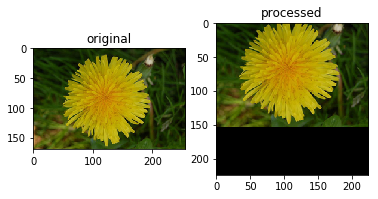

./flower_data/valid/88/image_00544.jpg


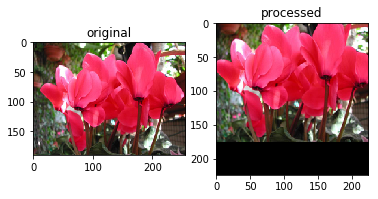

./flower_data/valid/34/image_06939.jpg


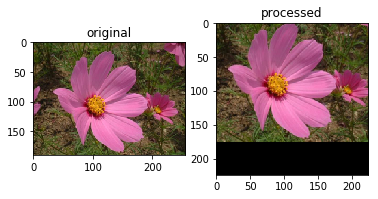

./flower_data/valid/44/image_01494.jpg


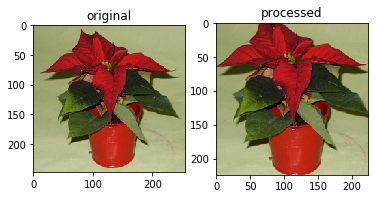

./flower_data/valid/53/image_03693.jpg


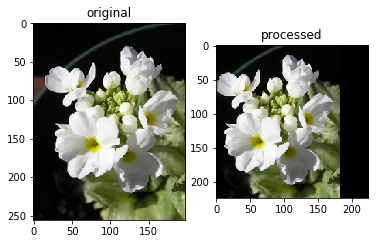

In [201]:
def process_image(image):
    global means
    global stds
    
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''

    # Process a PIL image for use in a PyTorch model

    size = resize_size, resize_size
    image.thumbnail(size, Image.ANTIALIAS)
    center = resize_size // 2
    padding = 224 // 2
    image = image.crop((
        center - padding,
        center - padding,
        center + padding,
        center + padding
    ))

    np_image = np.array(image) / 255.
    
    mean = np.array(means)
    std = np.array(stds)
    np_image = (np_image - mean) / std

    np_image = np_image.transpose(2, 0, 1)

    return np_image

def revert_process_image(image):
    global means
    global stds

    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array(means)
    std = np.array(stds)
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    return image
    

for image_path in test_image_paths:
    print(image_path)
    img = Image.open(image_path)
    processed_img = process_image(img)

    fig, (ax1, ax2) = plt.subplots(figsize=(6, 10), ncols=2, nrows=1)
    ax1.set_title('original')
    ax1.imshow(img)    
    ax2.set_title('processed')
    ax2.imshow(revert_process_image(processed_img))
    plt.show()


To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

./flower_data/valid/50/image_06544.jpg


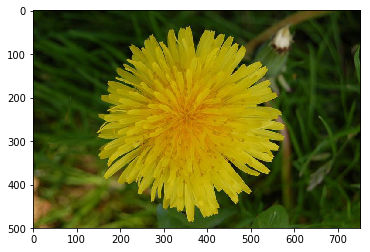

(array([9.9177235e-01, 7.8214118e-03, 1.5445951e-04, 1.2390003e-04,
       4.2286163e-05], dtype=float32), ['50', '12', '41', '5', '31'])

./flower_data/valid/88/image_00544.jpg


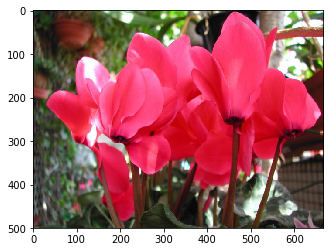

(array([9.9177235e-01, 7.8214118e-03, 1.5445951e-04, 1.2390003e-04,
       4.2286163e-05], dtype=float32), ['50', '12', '41', '5', '31'])

./flower_data/valid/34/image_06939.jpg


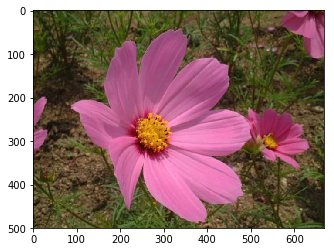

(array([9.9177235e-01, 7.8214118e-03, 1.5445951e-04, 1.2390003e-04,
       4.2286163e-05], dtype=float32), ['50', '12', '41', '5', '31'])

./flower_data/valid/44/image_01494.jpg


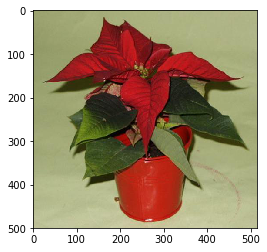

(array([9.9177235e-01, 7.8214118e-03, 1.5445951e-04, 1.2390003e-04,
       4.2286163e-05], dtype=float32), ['50', '12', '41', '5', '31'])

./flower_data/valid/53/image_03693.jpg


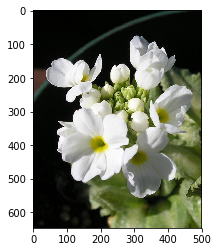

(array([9.9177235e-01, 7.8214118e-03, 1.5445951e-04, 1.2390003e-04,
       4.2286163e-05], dtype=float32), ['50', '12', '41', '5', '31'])



In [203]:
def predict(model, image_path, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    # Implement the code to predict the class from an image file

    # load
    image = torch.FloatTensor([process_image(Image.open(image_path))])

    # predict
    output = model.forward(Variable(image))
    
    # transform
    pobabilities = torch.exp(output).data.numpy()[0]
    top_idx = np.argsort(pobabilities)[-topk:][::-1] 
    top_class = [idx_to_class[x] for x in top_idx]
    top_probability = pobabilities[top_idx]

    return top_probability, top_class

for image_path in test_image_paths:
    print(image_path)
    img = Image.open(image_path)
    plt.imshow(img)
    plt.show()

    print(predict(loaded_model, test_path))
    print()

## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the validation accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

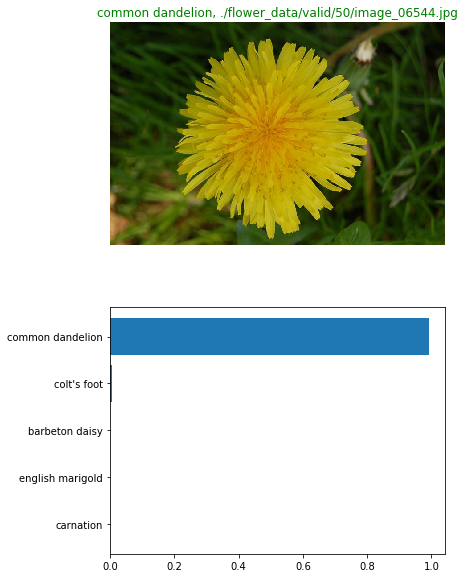

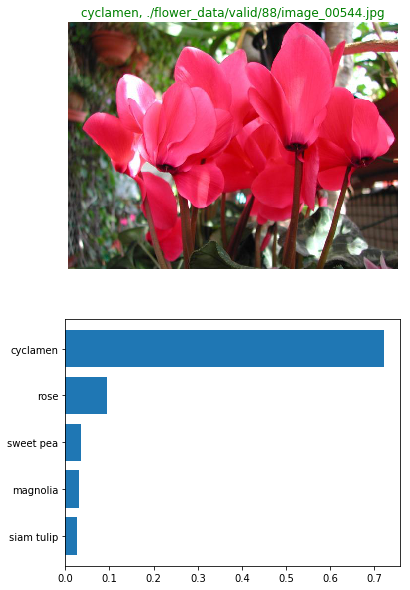

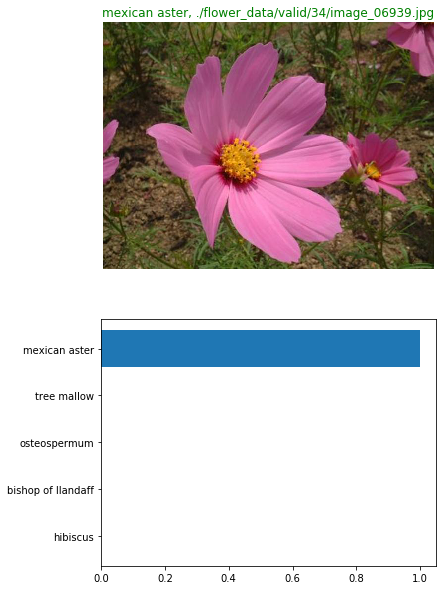

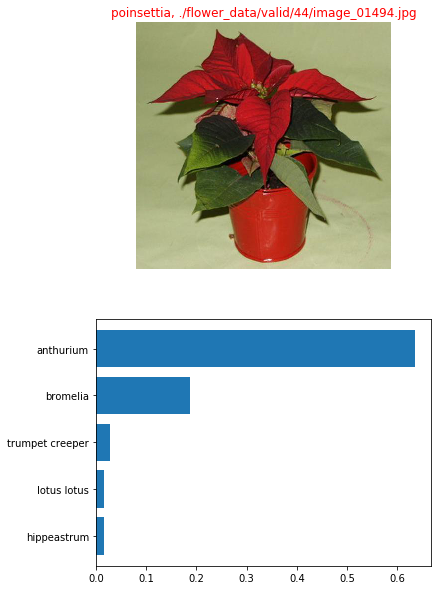

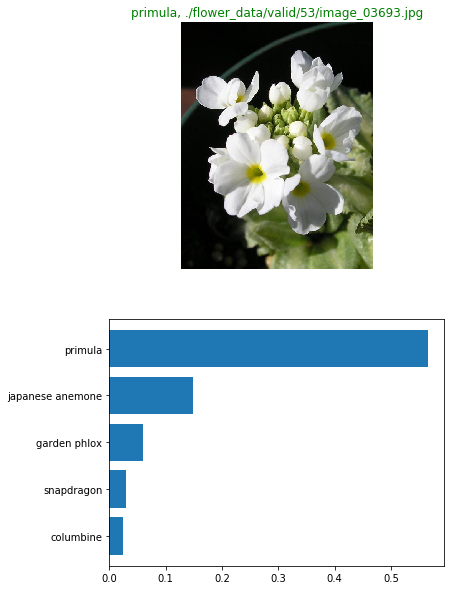

In [204]:
# Display an image along with the top 5 classes
def sanity_check(image_path, probabilities, classes, mapper):
    flower_cat_id = image_path.split('/')[-2]
    flower_cat_name = mapper[flower_cat_id]

    # load
    img = Image.open(image_path)
    
    # plot
    fig, (ax1, ax2) = plt.subplots(figsize=(6, 10), ncols=1, nrows=2)    
    title = '%s, %s' % (flower_cat_name, image_path)
    color=("green" if flower_cat_name == mapper[classes[0]] else "red")
    ax1.set_title(title, color=color)
    ax1.imshow(img)
    ax1.axis('off')

    y_pos = np.arange(len(probabilities))
    ax2.barh(y_pos, probabilities)
    ax2.set_yticks(y_pos)
    ax2.set_yticklabels([mapper[c] for c in classes])
    ax2.invert_yaxis()


for image_path in test_image_paths:
    probs, classes = predict(loaded_model, image_path)
    sanity_check(image_path, probs, classes, cat_to_name)